# A simple Neural Network for MNIST data

**Necessary imports**

In [1]:
import numpy as np
import tensorflow as tf
import skimage.measure
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

**Load and visualize MNIST dataset**

In the first part we want to implement a small neural network which detects handwritten digits. To this end we use the MNIST dataset which is extensively used as academic benchmark for machine learning algorithms. As it is a standard dataset, we can load it from Tensorflow's high-level API Keras. The following cell introduces the dataset:

type of training input: <class 'numpy.ndarray'>
type of training labels: <class 'numpy.ndarray'>
shape of training input: (60000, 14, 14)
shape of training labels: (60000,)
labels of 20 first training images: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


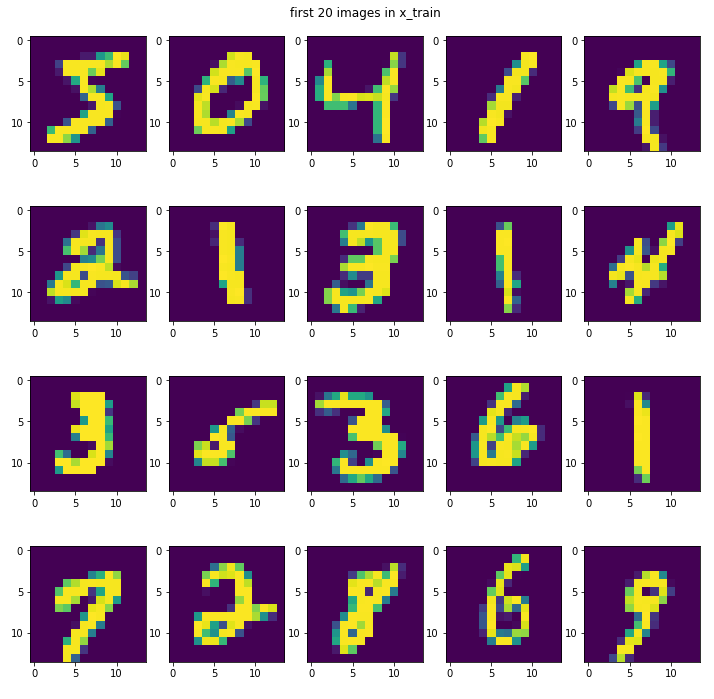

In [2]:
#load MNIST data
mnist = tf.keras.datasets.mnist
(x_train_large, y_train),(x_test_large, y_test) = mnist.load_data()
#scale int8 to the interval (0,1)
x_train_large, x_test_large = x_train_large / 255.0, x_test_large / 255.0

#reduce size of images
reduce_fac = 2
image_size = int(x_train_large.shape[-1]/reduce_fac)
x_train = np.zeros([len(x_train_large), image_size, image_size], dtype=np.float64)
x_test = np.zeros([len(x_test_large), image_size, image_size], dtype=np.float64)
for i in range(len(x_train_large)):
    x_train[i] = skimage.measure.block_reduce(x_train_large[i], (reduce_fac,reduce_fac), np.max)
for i in range(len(x_test_large)):
    x_test[i] = skimage.measure.block_reduce(x_test_large[i], (reduce_fac,reduce_fac), np.max)


#find out type of x_train and y_train
print("type of training input: " + str(type(x_train)))
print("type of training labels: " + str(type(y_train)))
#find out shapes of x_train and y_train
print("shape of training input: " + str(x_train.shape))
print("shape of training labels: " + str(y_train.shape))

#print first 20 labels in y_train
print("labels of 20 first training images: " + str(y_train[0:20]))

#plot first 20 images in x_train
fig = plt.figure(figsize=(12, 12))
plt.title("first 20 images in x_train")
plt.axis('off')
for i in range(20):
    sub = fig.add_subplot(4, 5, i + 1)
    sub.imshow(x_train[i])

**Notation**

 For the implementation of the neural network the following notation will be helpful. Nodes (neurons) are specified by a the specification of a layer and a numbering within that layer. Consequently the activation of the $j$-th node of layer $l$ is denoted by $x^{(l)}_j$. Similarlly the bias of this node is written as $b^{(l)}_j$. Let $x^{(l)}$ and $b^{(l)}$ be the column vectors containing all the activations and biases in layer $l$, respectively. Furthermore, except for the input layer, each layer $l$ is assigned one matrix $W^{(l)}$. The element $w^{(l)}_{jk}$ of the matrix $W^{(l)}$ represents the edge from node $k$ of layer $l-1$ to node $j$ of layer $l$ (siehe Abbildung 1). As discussed in the lecture, we will use the so-called bias trick, in order to have a unified notation for biases and weights in one matrix. This means that the bias vector is just the $0$-th column of $W^{(l)}$, i.e. $b^{(l)}=w^{(l)}_{j0}$, and the activation of the added $0$-th node is one, i.e. $x^{(l)}_0=1$. Finally we denote the activation function in layer $l$ by $f^{(l)}$ as it is assumed to be the same within one layer. It maps the accumulated input $z^{(l)} = W^{(l)}\cdot x^{(l-1)}$ of the layer to its activation $x^{(l)}$.

<img src="nn_layer.png" style="width:50%;">
<caption><center> <u> Abbildung 1 </u>: Weight matrix for one layer $l$ of a feedforward network. Note that the bias trick is not included in the picture.<br> </center></caption>

**Network architecture**

 We will use a simple fully-connected feedforward network with three layers, one input layer one hidden layer and one output layer. The size of the input layer is determined by the image size (number of pixels). We choose the hidden layer to have $30$ and the output layer as many nodes as there are possible labels. The output is (up to normalization) interpreted as probability distribution over the ten digits: The output of the $i$-th node represents the probablity that the input is an image of a digit $i\in\{0,9\}$. E.g., the output vector $\left(1,0,0,0,0,0,0,0,0,0\right)$ corresponds to a $100\%$-certainty that the image shows a zero. This kind of class-encoding is often called one-hot-encoding. In order to guarantee that the activations in the last layer are normalized and lie in the interval $[0,1]$, we use the softmax activation function
<br><br>\begin{align}
f_i^{(2)}\left(\{z_k\}\right)=\frac{\exp{z_i}}{\sum_k \exp{z_k}}.
\end{align}<br>
For $f^{(1)}$ we will use the logistic function (often called sigmoid function)
<br><br>\begin{align}
f_i^{(1)}\left(\{z_k\}\right)=\frac{1}{1+\exp{-z_i}}.
\end{align}<br><br>

In [3]:
#set sizes of layers
input_size = np.prod(x_train[0].shape)
hidden_size = 30
output_size = 10

In [7]:
#define first layer activation function: logistic function
def f_1(x):
    if(x>=0):
        z = np.exp(-x)
        return 1/(1+z)
    else:
        z = np.exp(x)
        return z/(1+z)
#vectorization of f_1
v_f_1 = np.vectorize(f_1)

#define second layer activation function: softmax function
def f_2(x, delta=10**(-8)):
    shift_x = x - np.max(x)
    y = np.exp(shift_x)/(np.sum(np.exp(shift_x), axis=0) + delta)
    return y

**Initialization of weights**

We generate small, random, initial weight matrices by sampling from a standard normal distribution $\cal{N}(0,\sigma)$ with $\sigma=0.001$. The matrices need to have dimensions which are consistent with the network architecture and the bias trick.

In [8]:
#define function that returns initial weight matrices (including biases)
def init_weights(input_size, hidden_size, output_size, sigma=0.0001):
    
    #generate first layer weight matrix
    W_1 = np.random.normal(0, sigma, [hidden_size,input_size+1])
    
    #generate second layer weight matrix
    W_2 = np.random.normal(0, sigma, [output_size,hidden_size+1])
    
    return W_1, W_2

**Forward Propagation (Prediction)**

Applying the bias trick, the forward propagation across the layer $l$, then reads
<br><br>
\begin{align}
x^{(l)} = f^{(l)}\left(W^{(l)}\cdot x^{(l-1)}\right).
\end{align}<br>
In our present example we define input, hidden and output layer to be layer $0$, $1$ and $2$, respectively. The two weight matrices $W^{(1)}$ (shape: $30\times(196+1)$) and $W^{(2)}$ (shape: $10\times(30+1)$) together with the activation functions $f^{(1)}$ and $f^{(2)}$ completely define the forward propagation through the network of an input $x^{(0)}$ to an output $y_{pred}$:
<br><br>\begin{align}
  y_{pred} = x^{(2)} = f^{(2)}\left(W^{(2)}\cdot f^{(1)}\left(W^{(1)}\cdot x^{(0)}\right)\right).
\end{align}<br>
Since we do not only have one training example, it would be interesting to process $n$ several training examples to the same time in so-called batches. This can be done via extension of the vector $x^{(0)}$ to a matrix $X^{(0)}$, where each column of $X^{(0)}$ represents one training example. All the other involved vectors are casted to matrices by the added batch size dimension, too. E.g. $Y_{pred}$ has shape $10\times n$.
<br><br>\begin{align}
  Y_{pred} = X^{(2)} = f^{(2)}\left(W^{(2)}\cdot f^{(1)}\left(W^{(1)}\cdot X^{(0)}\right)\right).
\end{align}<br>

In [16]:
#function that returns the activation of all layers given input and weight matrices
def predict(x, W_1, W_2):
    
    #cast array of 2-d images into a matrix of shape batch_size*input_size
    batch_size = x.shape[0]
    X_0 = x.reshape(batch_size, input_size).T
    #add bias input 
    X_0 = np.insert(X_0, 0, np.ones(batch_size), axis=0)
    #matrix multiplication of first layer
    
    Z_1 = np.matmul(W_1, X_0)
    #apply activation function of first layer
    X_1 = v_f_1(Z_1)
    #add bias input
    X_1 = np.insert(X_1, 0, np.ones(batch_size), axis=0)
    
    #matrix multiplication of second layer
    Z_2 = np.matmul(W_2, X_1)
    #apply activation function of second layer
    Y_pred = f_2(Z_2)
    
    return X_0, X_1, Y_pred

**Regularized cross entropy loss and gradient**

The network learns from training samples based on a loss function. This is usually some kind of distance measure between the forward propageted training batch (i.e., the network output $Y_{pred}$) and the actual label of the batch encoded in $Y$. $Y$ has shape $n\times10$ ($i$-th row = $i$-th batch element, $j$-th column = probablities for digit $j$) and its elements are
<br><br>\begin{align}
y_{ij}=\begin{cases}
1 & \text{$i$-th batch element has label j}\\
0 & \text{otherwise}.
\end{cases}
\end{align}<br>
If the network output represents a probability distribution, one often uses the cross-entropy loss function. In our case the latter can be written as
<br><br>\begin{align}
{\cal{L}}=\sum_i\log{\left[(Y\cdot Y_{pred})_{ii}\right]}.
\end{align}<br>
The gradient with respect to the weight matrices is calculated for you in the function ce_gradient.

In [17]:
#function that transforms digit label {0,1,...,9} to one-hot-encoding matrices of shape n*10
def one_hot_mat(y_train):
    
    #get batch_size
    batch_size = y_train.shape[0]
    
    #initialize matrix with zeros
    Y_train = np.zeros([batch_size, output_size])
    
    #fill matrix with ones
    for k in range(batch_size):
        Y_train[k,y_train[k]] = 1.
        
    return Y_train

#define error function
def cross_entropy(X_train, y_train, W_1, W_2):
    
    #get batch_size
    batch_size = x_train.shape[0]
    
    #get prediction
    Y_pred = predict(X_train, W_1, W_2)[-1]
    
    #get one_hot_encoded label matrix
    Y_train = one_hot_mat(y_train)

    #calculate error
    err = np.sum(np.log(np.diagonal(np.matmul(Y_train, Y_pred))))/batch_size
    
    return err

#define gradient function
def ce_gradient(y, y_pred, x_1, x_0, W_1, W_2, l_2_reg=0.5):
    
    #get batch_size
    batch_size = y_pred.shape[1]
    
    #cross entropy loss gradient for W_1
    grad_W_1 = -(np.matmul(x_0, (x_1.T*(1.-x_1).T*(W_2[y]-np.matmul(y_pred.T, W_2)))[:,1:]).T)/batch_size
    
    #l2-regularization loss for W_1
    grad_W_1 += l_2_reg * W_1
    
    #cross entropy loss gradient for W_2
    grad_W_2 = -(np.matmul(x_1, (one_hot_mat(y)-y_pred.T)).T)/batch_size
    
    #l2-regularization loss for W_2
    grad_W_2 += l_2_reg * W_2
    
    return grad_W_1, grad_W_2

**Define accuracy function**

In [18]:
def accuracy(X, y_train, W_1, W_2):
    
    #get prediction
    output = np.argmax(predict(X, W_1, W_2)[-1], axis=0)
    
    #count correct classifiations
    acc = np.sum(output == y_train)
    
    #normalize to batch size
    acc = acc/len(X)
    
    return acc

**Definition of training function (Adam optimizer)**

The Adam optimizer is a state-of-the-art optimization method for neural networks. It is gradient-based, includes a momentum term to avoid local minima and adapts the step sizes via the estimation of the gradient's second moment.

In [57]:
#define function that returns the updated weights
def adam_opt(X_train, y_train, W_2, W_1, rate = 0.001, iterations=1000, batch_size=16, l_2_reg=0.5, decay_rate_s=0.9, decay_rate_r=0.999, delta = 10**(-8)):
        
    s_1 = np.zeros(W_1.shape)
    r_1 = np.zeros(W_1.shape)
    s_2 = np.zeros(W_2.shape)
    r_2 = np.zeros(W_2.shape)
    
    acc_list = []
    for i in range(iterations):
        
        #get random training sample
        rand = np.random.randint(0, len(x_train), batch_size)
        x = X_train[rand]
        y = y_train[rand]
        
        #prediction of network
        x_0, x_1, y_pred = predict(x, W_1, W_2)
        #calculate gradients of cross entropy loss
        grad_W_1, grad_W_2 = ce_gradient(y, y_pred, x_1, x_0, W_1, W_2, l_2_reg)
        
        #first moment estimation for W_1
        s_1 *= decay_rate_s
        s_1 += (1-decay_rate_s) * grad_W_1
        #second moment estimation for W_1
        r_1 *= decay_rate_r
        r_1 += (1-decay_rate_r) * np.square(grad_W_1)
        #first moment estimation for W_2
        s_2 *= decay_rate_s
        s_2 += (1-decay_rate_s) * grad_W_2
        #second moment estimation for W_2
        r_2 *= decay_rate_r
        r_2 += (1-decay_rate_r) * np.square(grad_W_2)
        
        #bias correction
        s_1_dag = s_1/(1-decay_rate_s**(i+1))
        r_1_dag = r_1/(1-decay_rate_r**(i+1))
        s_2_dag = s_2/(1-decay_rate_s**(i+1))
        r_2_dag = r_2/(1-decay_rate_r**(i+1))

        #calculate updated first layer weight matrix
        W_1_new = W_1 - rate * s_1_dag/(np.sqrt(r_1_dag) + delta)
        
        #calculate updated second layer weight matrix
        W_2_new = W_2 - rate * s_2_dag/(np.sqrt(r_2_dag) + delta)
        
        #keep track of accuracy (comment out if execution takes too long)
        if(i%100 == 0):
            acc_list.append([i, accuracy(x_train, y_train, W_1, W_2)])
        
        #update weight matrices
        W_1, W_2 = W_1_new, W_2_new
    
    return W_1_new, W_2_new, acc_list

**Execute training**

If the execution takes too long try to comment out the lines under "#keep track of accuracy" in the function adam_opt. In the last line of the following cell one can adjust some parameters of the training process.

In [60]:
#set random seed for reproducible results
np.random.seed(1)

#initialize weights
W_1, W_2 = init_weights(input_size, hidden_size, output_size)

#execution of training via adam optimizer
W_1, W_2, acc_list = adam_opt(x_train, y_train, W_2, W_1, rate = 0.01, iterations=1000, batch_size=32, l_2_reg=0.000, decay_rate_s=0.9, decay_rate_r=0.999)

**Validation via accuracy**

training accuracy: 92.1 %
test accuracy: 92.1 %


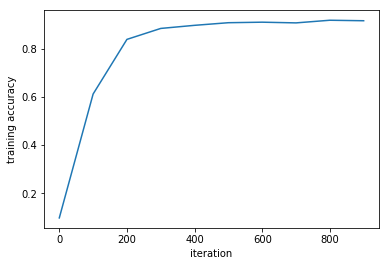

In [61]:
#calculate accuracy on training data
acc = accuracy(x_train, y_train, W_1, W_2)
print("training accuracy: " + str(round(100*acc,1)) + " %")


#calculate accuracy on test data
acc = accuracy(x_test, y_test, W_1, W_2)
print("test accuracy: " + str(round(100*acc,1)) + " %")

#plot of accuracy over iterations
xx=np.array(acc_list)[:,0]
yy=np.array(acc_list)[:,1]
plt.xlabel('iteration')
plt.ylabel('training accuracy')
plt.plot(xx,yy)
plt.show()

**Visualization of result for a random image**

Look at the results for different randomly chosen images from the test set. For this just repeatedly execute the following cell. Are there numbers that are misclassified by the network more often?

prediction for the random image: 
[[0.01]
 [0.  ]
 [0.01]
 [0.69]
 [0.  ]
 [0.02]
 [0.  ]
 [0.  ]
 [0.27]
 [0.  ]]


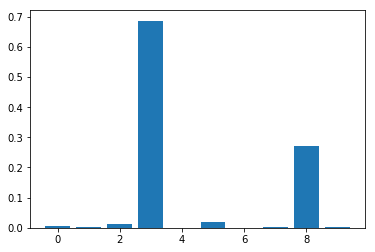

label of the random image: 3


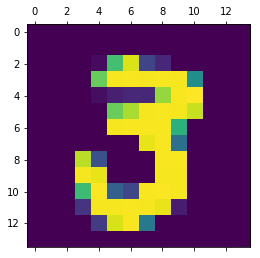

In [63]:
#get random image
rand = [np.random.randint(0, len(x_test))]

#get prediction for random image from x_test
x_0, x_1, x_2 = predict(x_test[rand], W_1, W_2)

#print and plot prediction
print("prediction for the random image: ")
print(np.round(x_2,2))
xx=range(0,10)
yy=x_2[:,0]
plt.xscale('linear')
plt.yscale('linear')
plt.bar(xx,yy)
plt.show()

#print label, plot image
plt.matshow(x_test[rand[0]])
print("label of the random image: " + str(*y_test[rand]))

**Play with parameters**

The training of the neural network already works ok for the chosen parameters. However, the parameters are not optimal. Just change the parameters (learning rate, batch size, iterations, size of hidden layer, size of input image(e.g., set reduce_fac to 1), ...) in the above code and observe the change of training performance.

# Gradient-based optimization

In the second part we want to look at the different behaviour of gradient-based optimizers. To this end we consider a one-dimensional objective function which should be minimized. Note that the gradient is calculated via an exact analytical formula for the derivative. This is different from above where it is only approximated.

**Necessary imports**

In [64]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

**Definition of objective function**

First we define and plot the objective function. It is designed to have many local minima.

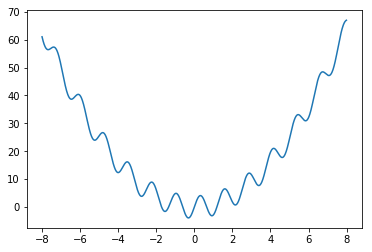

In [65]:
#parameters of oscillating error function
omega = 5
amplitude = 4
#set plot resolution
resolution=0.01

#oscillating error
def error_osci(x):
    y = x**2 + amplitude*np.sin(omega*x)
    return y
#according gradient
def error_osci_grad(x):
    y = 2*x + amplitude*omega*np.cos(omega*x)
    return y

#plot objective function
fig, ax = plt.subplots()
x = np.arange(-8, 8, 0.01)
y = error_osci(x)
ax.plot(x, y)

**Definition of different optimizers**

In [66]:
def gradient_descent(error, error_grad, x_init, step_size=0.001, iterations=100):
    x_min = x_init
    history = [[x_init,error(x_init)]]
    for i in range(iterations):
        grad = error_grad(x_min)
        x_min -= step_size * grad
        history.append([x_min, error(x_min)])
    return history

def ada_grad(error, error_grad, x_init, step_size=0.001, iterations=100, delta=10**(-7)):
    x_min = x_init
    history = [[x_init,error(x_init)]]
    r = 0
    for i in range(iterations):
        grad = error_grad(x_min)
        r += np.square(grad)
        x_min -= step_size/(np.sqrt(r)+delta) * grad
        history.append([x_min, error(x_min)])
    return history

def RMS_prop(error, error_grad, x_init, step_size=0.001, decay_rate=0.8, iterations=100, delta=10**(-6)):
    x_min = x_init
    history = [[x_init,error(x_init)]]
    r = 0
    for i in range(iterations):
        grad = error_grad(x_min)
        r *= decay_rate
        r += (1-decay_rate) * np.square(grad)
        x_min -= step_size/np.sqrt(r+delta) * grad
        history.append([x_min, error(x_min)])
    return history

def adam(error, error_grad, x_init, step_size=0.001, decay_rate_1=0.9, decay_rate_2=0.999, iterations=100, delta=10**(-8)):
    x_min = x_init
    history = [[x_init,error(x_init)]]
    s = 0
    r = 0
    for i in range(iterations):
        grad = error_grad(x_min)
        #first moment estimation
        s *= decay_rate_1
        s += (1-decay_rate_1) * grad
        #second moment estimation
        r *= decay_rate_2
        r += (1-decay_rate_2) * np.square(grad)
        #bias correction
        s_dag = s/(1-decay_rate_1**(i+1))
        r_dag = r/(1-decay_rate_2**(i+1))
        x_min -= step_size*s_dag/(np.sqrt(r_dag)+delta)
        history.append([x_min, error(x_min)])
    return history

**Definition of plotting function**

In [67]:
left=-9
right=7
def plot_history(i, error, history):
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    optimizer = list(history.keys())
    #error function
    x = np.arange(left, right, resolution)
    y = error(x)
    ax.plot(x, y)
    #iteration step
    for k in range(len(optimizer)):
        if(i==0):
            ax.plot(*np.array(history[optimizer[k]][0]).T.tolist(), color=colors[k], marker='o')
        else:
            ax.plot(*np.array(history[optimizer[k]][:i+1]).T.tolist(), color=colors[k], marker='o')
    ax.grid()
    plt.legend(("error",)+tuple(optimizer), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    return

**Plotting**

Observe the optimization process of the different methods (you can comment them in/out in the dictionary "history"), especially plain gradient descent and Adam. Play with the learning rates (step_size_...) of the different optimizers and see how the behaviour changes.

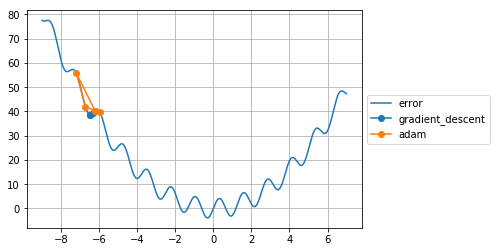

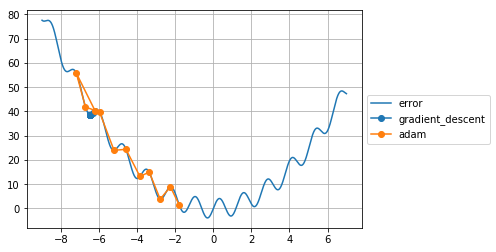

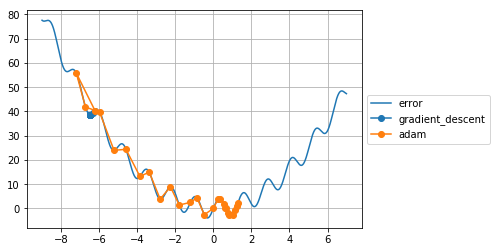

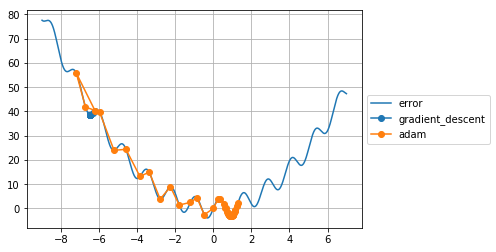

In [68]:
#initial point
x_init = -6.2

#number of iteration steps
iterations = 50

#step size or learning rate of gradient-based algorithms
step_size_gd = 0.02
step_size_ag = 1.2
step_size_RMS = 0.5
step_size_adam = 1
#decay rate of past squared gradients for RMS_prop
decay_rate = 0.9
#decay rate of past gradients for adam
decay_rate_1 = 0.9
#decay rate of past squared gradients for adam
decay_rate_2 = 0.999

#apply gradient-based methods and save history
history = {
            "gradient_descent": gradient_descent(error_osci, error_osci_grad, x_init, step_size_gd, iterations)
           #,"ada_grad": ada_grad(error_osci, error_osci_grad, x_init, step_size_ag, iterations)
           #,"RMS_prop": RMS_prop(error_osci, error_osci_grad, x_init, step_size_RMS, decay_rate, iterations)
           ,"adam": adam(error_osci, error_osci_grad, x_init, step_size_adam, decay_rate_1, decay_rate_2, iterations)
          }

#plot
for i in [3,10,25,50]:
    iteration = i
    plot_history(iteration, error_osci, history)